In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


## Load and inspect simulation data

In [86]:
import pandas
import seaborn
from scipy.stats import skew, entropy, kurtosis, gaussian_kde, pearsonr
from os import listdir
from SuchTree import SuchTree, SuchLinkedTrees
from pyprind import ProgBar

reading data, building graphs...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


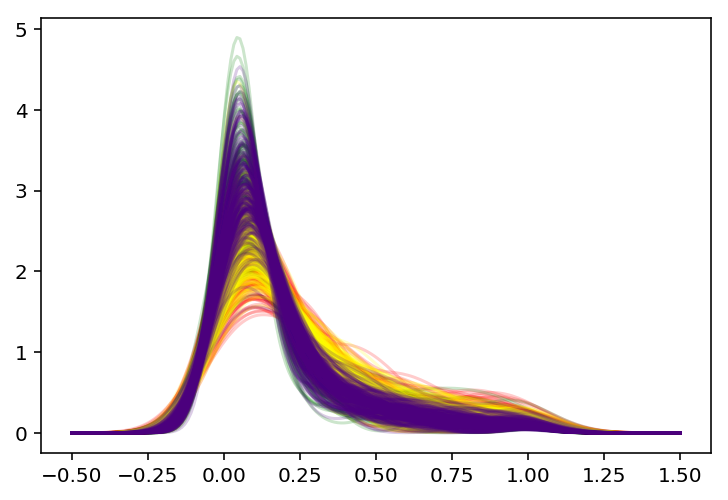

In [328]:
X = linspace( -0.5, 1.5, 200 )

path_noswitch_slow     = { 'path'  : 'simulations/noswitch_slow/',
                           'label' : 'noswitch_slow',
                           'switch': 'none',
                           'g_evol': 'slow',
                           'color' : 'red' }
path_noswitch_balanced = { 'path'  : 'simulations/noswitch_balanced/',
                           'label' : 'noswitch_balanced',
                           'switch': 'none',
                           'g_evol': 'balanced',
                           'color' : 'blue' }
path_noswitch_fast     = { 'path'  : 'simulations/noswitch_fast/',
                           'label' : 'noswitch_fast',
                           'switch': 'none',
                           'g_evol': 'fast',
                           'color' : 'green' }

path_slowswitch_slow     = { 'path'  : 'simulations/slowswitch_slow/',
                             'label' : 'slowswitch_slow',
                             'switch': 'slow',
                             'g_evol': 'slow',
                             'color' : 'pink' }
path_slowswitch_balanced = { 'path'  : 'simulations/slowswitch_balanced/',
                             'label' : 'slowswitch_balanced',
                             'switch': 'slow',
                             'g_evol': 'balanced',
                             'color' : 'black' }
path_slowswitch_fast     = { 'path'  : 'simulations/slowswitch_fast/',
                             'label' : 'slowswitch_fast',
                             'switch': 'slow',
                             'g_evol': 'fast',
                             'color' : 'purple' }

path_fastswitch_slow     = { 'path'  : 'simulations/fastswitch_slow/',
                             'label' : 'fastswitch_slow',
                             'switch': 'fast',
                             'g_evol': 'slow',
                             'color' : 'yellow' }
path_fastswitch_balanced = { 'path'  : 'simulations/fastswitch_balanced/',
                             'label' : 'fastswitch_balanced',
                             'switch': 'fast',
                             'g_evol': 'balanced',
                             'color' : 'brown' }
path_fastswitch_fast     = { 'path'  : 'simulations/fastswitch_fast/',
                             'label' : 'fastswitch_fast',
                             'switch': 'fast',
                             'g_evol': 'fast',
                             'color' : 'indigo' }

#allsims = [ path_noswitch_slow,   path_noswitch_balanced,   path_noswitch_fast,
#            path_slowswitch_slow, path_slowswitch_balanced, path_slowswitch_fast,
#            path_fastswitch_slow, path_fastswitch_balanced, path_fastswitch_fast]

allsims = [ path_noswitch_slow,    path_noswitch_fast,
            path_fastswitch_slow,  path_fastswitch_fast]

moments = []
data = []
spectra = []
SLTs = []
igraphs = []

p = ProgBar( sum( [ len(i) for i in [ listdir(sim['path']) for sim in allsims ] ] ),
             title='reading data, building graphs...' )

for sim in allsims :
    for run in listdir( sim['path'] ) :
        if run.endswith( '.log' ) : p.update(); continue
        
        sim['run'] = run
        path = sim['path'] + run + '/'
        
        # read the calculated eigenvalues, build density distribution
        eg = array( map( float, open( path + 'eigenvalues.csv').readline().split()[1].split(',') ) )
        density = gaussian_kde( eg/max(eg), bw_method=0.4 ).pdf( X )
        
        # read the calculated moments, build a DataFrame row
        moments.append( pandas.read_csv( path + 'moments.csv' ) )
        d = pandas.read_csv( path + 'data.csv' )
        d = pandas.DataFrame([sim]).join(d)
        data.append( d )
        
        # plot the spectral densities
        spectra.append( density )
        plot( X, density, color=sim['color'], alpha=0.2 )
        
        # build the graph objects
        T1 = SuchTree( path + 'host.relaxed.tree' )
        T2 = SuchTree( path + 'guest.relaxed.tree' )
        LK = pandas.read_csv( path + 'links.csv', index_col=0 )
        SLT = SuchLinkedTrees( T1, T2, LK )
        SLTs.append( SLT )
        igraphs.append( SLT.to_igraph() )
        
        p.update()
    
moments = pandas.concat( moments, ignore_index=True )
data = pandas.concat( data, ignore_index=True )

In [329]:
q = moments.join(data)
q.head()

,eigengap,skew,occupancy,treedist,p,r,squareness,kurtosis,color,g_evol,...,duplication_rate,prefix,guest_leafs,theta,k,loss_rate,min_guest_leafs,host_leafs,max_guest_leafs,max_host_leafs
0,0.402328,1.408328,1.083333,0.269036,7.163495e-17,0.775996,0.846154,0.722919,red,slow,...,0.0125,simulations/noswitch_slow/run155,13,0.5,2.0,0.0025,8,11,128,128
1,0.211525,1.663133,1.047619,0.476792,3.970014e-08,0.660971,0.909091,1.321065,red,slow,...,0.0125,simulations/noswitch_slow/run170,11,0.5,2.0,0.0025,8,10,128,128
2,1.355329,1.278524,1.000000,0.337718,7.973852e-10,0.669448,1.000000,0.405845,red,slow,...,0.0125,simulations/noswitch_slow/run162,12,0.5,2.0,0.0025,8,12,128,128
3,0.517264,1.161103,1.000000,0.216081,8.119788e-02,0.262752,1.000000,0.148095,red,slow,...,0.0125,simulations/noswitch_slow/run14,10,0.5,2.0,0.0025,8,10,128,128
4,0.264688,1.177534,1.000000,0.368741,6.678923e-11,0.795422,1.000000,0.005396,red,slow,...,0.0125,simulations/noswitch_slow/run165,10,0.5,2.0,0.0025,8,10,128,128


Text(0.5,0,u'graph density')

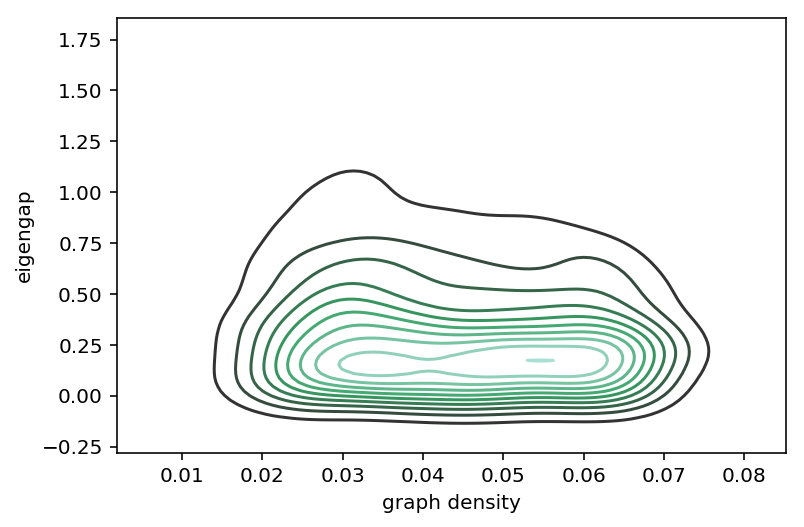

In [330]:
#scatter( q.occupancy, q.treedist )

seaborn.kdeplot( [ ig.density() for ig in igraphs ], q.eigengap )
xlabel( 'graph density' )

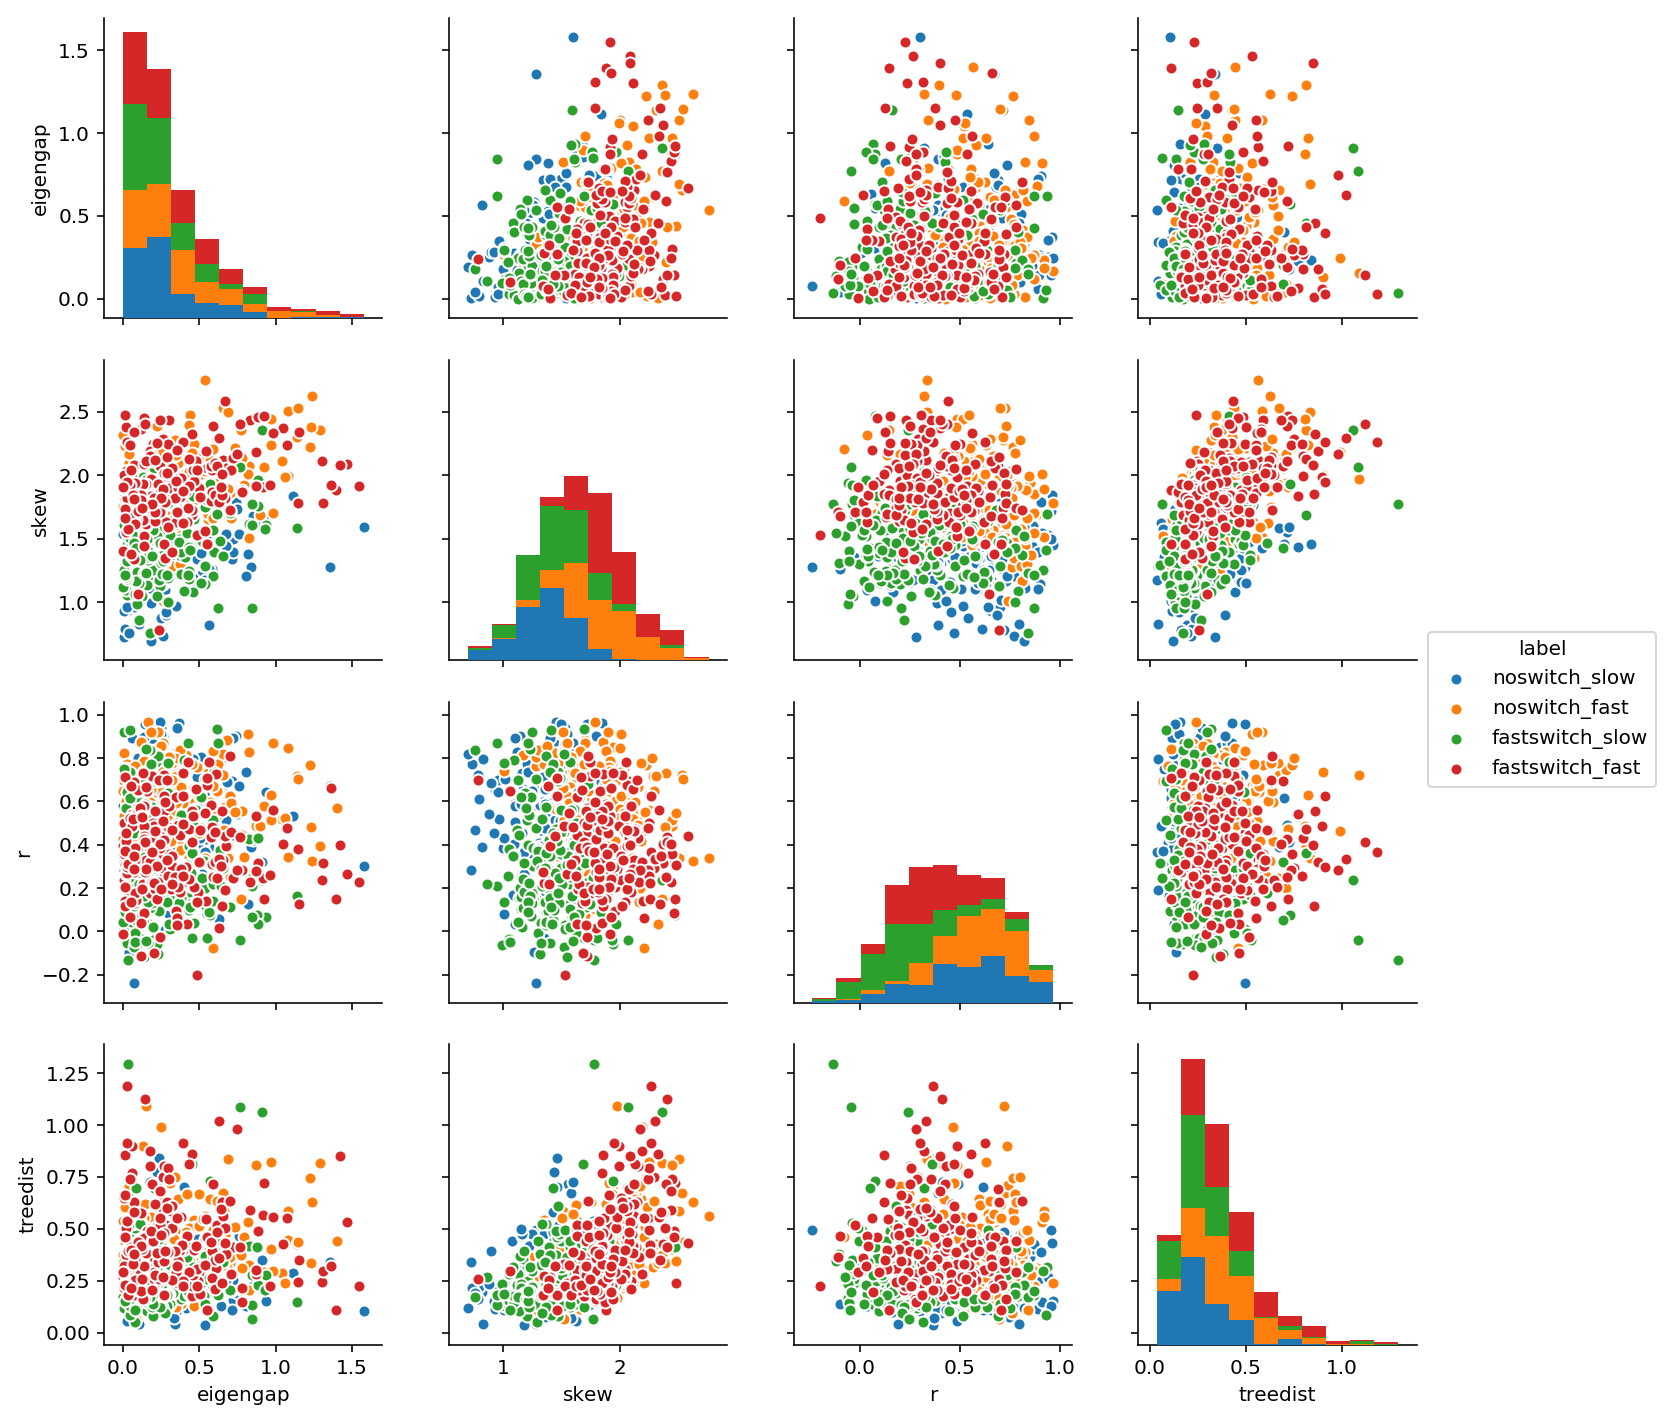

In [331]:
seaborn.pairplot( q.dropna(), vars=['eigengap', 'skew', 'r', 'treedist',], hue='label' )

We expepect that as the spectral distance between the tree components of a graph increases
(indicating more dissimilar tree topology), the Hommola correlation of the interaction graph
should decrease. They are indeed inversely correlated, though not strongly so (r=-0.055, p=0.019).

(-0.044572852022894835, 0.20789841888354058)


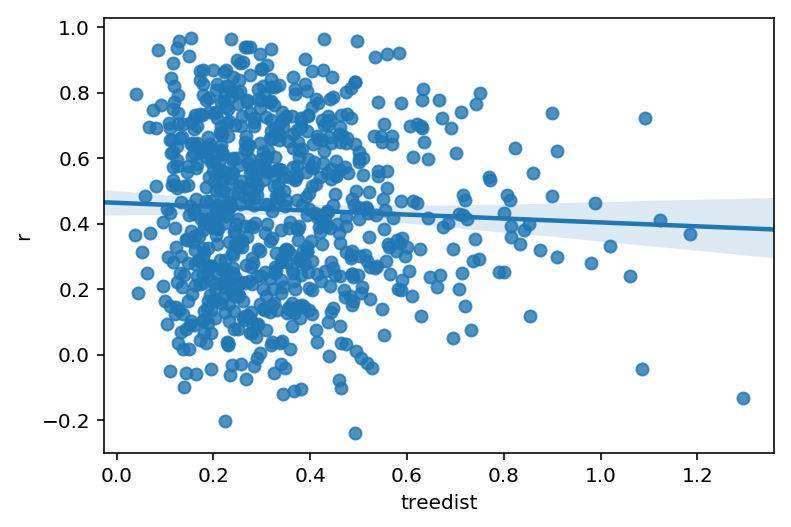

In [332]:
seaborn.regplot( x='treedist', y='r', data=q.dropna() )
print pearsonr( q.dropna().treedist, q.dropna().r ) 

## Clustering with graph moments

In [333]:
# This code is adapted from BiWeb
# https://github.com/tpoisot/bipy/blob/master/bipy/nes/nodf.py

def adjacency(W):
    # from BiWeb 
    adj = numpy.copy(W)
    adj[adj>0] = 1
    return adj

def generality(W):
    # from BiWeb
    ad = adjacency(W)
    gen = numpy.sum(ad,axis=1)
    return gen

def vulnerability(W):
    # from BiWeb
    ad = adjacency(W)
    vul = numpy.sum(ad,axis=0)
    return vul

def v_rank(V):
    # from BiWeb
    # Returns the rank of a vector
    # with no ties
    rn = numpy.zeros(len(V),dtype=numpy.int32)
    crnk = 0
    while crnk < len(V):
        for j in xrange(0,len(V)):
            cMax = numpy.max(V)
            if V[j] == cMax:
                rn[j] = crnk
                crnk += 1
                V[j] = numpy.min(V)-1
                break
    return rn

def sortbydegree(W):
    # from BiWeb
    # Sort a matrix by degree
 
    g = generality(W)
    v = vulnerability(W)
    upsp = len(W)
    losp = len(W[0])
    web = W
    ## Step 1 : sort TLO
    rG = v_rank( g )
    nW = numpy.zeros((upsp,losp))
    for ro in range(0,upsp):
        nW[rG[ro]] = web[ro]
    ## Step 2 : sort BLO
    nW = nW.T
    dW = numpy.zeros((upsp,losp)).T
    rG = v_rank(v)
    for ro in range(0,losp):
        dW[rG[ro]] = nW[ro]
    Fweb = numpy.copy(dW.T)

    return Fweb

def nestadj(aW):
    # from BiWeb
    return adjacency(sortbydegree(aW))

def compareones(w1,w2,tn):
    # from BiWeb
    if tn == 0 : return 0.0
    return numpy.sum( (w1+w2) == 2 )/tn

def getNpaired(W):
    # Required for NODF calculation
    # Get the N paired value of a web
    Npaired = []
    gen = generality(W)
    for i in xrange(0,(len(W)-1)):
        for j in xrange((i+1),len(W)):
            if gen[i] >= gen[j]:
                Npaired.append(compareones(W[i],W[j],gen[j]))
            else :
                Npaired.append(0.0)
    return Npaired

def nodf(aW):
    # from BiWeb
    """
    The strict boolean tells if the condition for overlap needs to be
    strictly enforced or not. If srict = False, this can somehow increase the NODF
    values.
    """
    if (len(aW[0])==1)|(len(aW)==1):
        return [0,0,0]
    W = nestadj(aW)
    NProw = getNpaired(W)
    NPcol = getNpaired(W.T)
    # Output the NODF value
    ColCor = (len(W[0])*(len(W[0])-1))/2.0
    RowCor = (len(W)*(len(W)-1))/2.0
    NrowSum = numpy.sum( NProw )
    NcolSum = numpy.sum( NPcol )
    WholeNest = (NcolSum+NrowSum)/(ColCor + RowCor)
    ColNest = NcolSum/ColCor
    RowNest = NrowSum/RowCor
    return WholeNest, ColNest, RowNest

In [334]:
gm = q[[ 'eigengap', 'skew', 'occupancy', 'treedist', 'r', 'p', 'squareness', 'kurtosis' ]]

gm = gm.join( pandas.DataFrame( [ ig.diameter() for ig in igraphs ], columns=['diameter'] ) )
gm = gm.join( pandas.DataFrame( [ mean(ig.eccentricity()) for ig in igraphs ], columns=['eccentricity'] ) )
gm = gm.join( pandas.DataFrame( [ mean(ig.betweenness()) for ig in igraphs ], columns=['mean_betweenness'] ) )
gm = gm.join( pandas.DataFrame( [ std(ig.betweenness()) for ig in igraphs ], columns=['std_betweenness'] ) )
gm = gm.join( pandas.DataFrame( [ ig.modularity( ig.vs['tree'] ) for ig in igraphs], columns=['modularity'] ) )
#gm = gm.join( pandas.DataFrame( [ nodf( SLT.linkmatrix ) for SLT in SLTs ], columns=['WholeNest', 'ColNest', 'RowNest'] ) )
gm = gm.join( pandas.DataFrame( [ nodf( SLT.linkmatrix )[0] for SLT in SLTs ], columns=['nestedness'] ) )

gm.head()

,eigengap,skew,occupancy,treedist,r,p,squareness,kurtosis,diameter,eccentricity,mean_betweenness,std_betweenness,modularity,nestedness
0,0.402328,1.408328,1.083333,0.269036,0.775996,7.163495e-17,0.846154,0.722919,10,8.804348,91.804348,88.524141,0.269468,0.022556
1,0.211525,1.663133,1.047619,0.476792,0.660971,3.970014e-08,0.909091,1.321065,8,7.400000,69.325000,63.948308,0.274677,0.010000
2,1.355329,1.278524,1.000000,0.337718,0.669448,7.973852e-10,1.000000,0.405845,10,8.869565,93.086957,86.108327,0.285714,0.000000
3,0.517264,1.161103,1.000000,0.216081,0.262752,8.119788e-02,1.000000,0.148095,9,8.052632,68.578947,60.162928,0.282609,0.000000
4,0.264688,1.177534,1.000000,0.368741,0.795422,6.678923e-11,1.000000,0.005396,9,8.210526,69.842105,61.467668,0.282609,0.000000


In [335]:
from sklearn.manifold import TSNE, MDS, Isomap

gm_embedded = pandas.DataFrame( TSNE(n_components=2, perplexity=100).fit_transform( gm.dropna() ), 
                                columns=['tSNEx','tSNEy'] )
#gm_embedded = pandas.DataFrame( MDS(n_components=2, metric=True ).fit_transform( gm.dropna() ), 
#                                columns=['MDSx','MDSy'] )

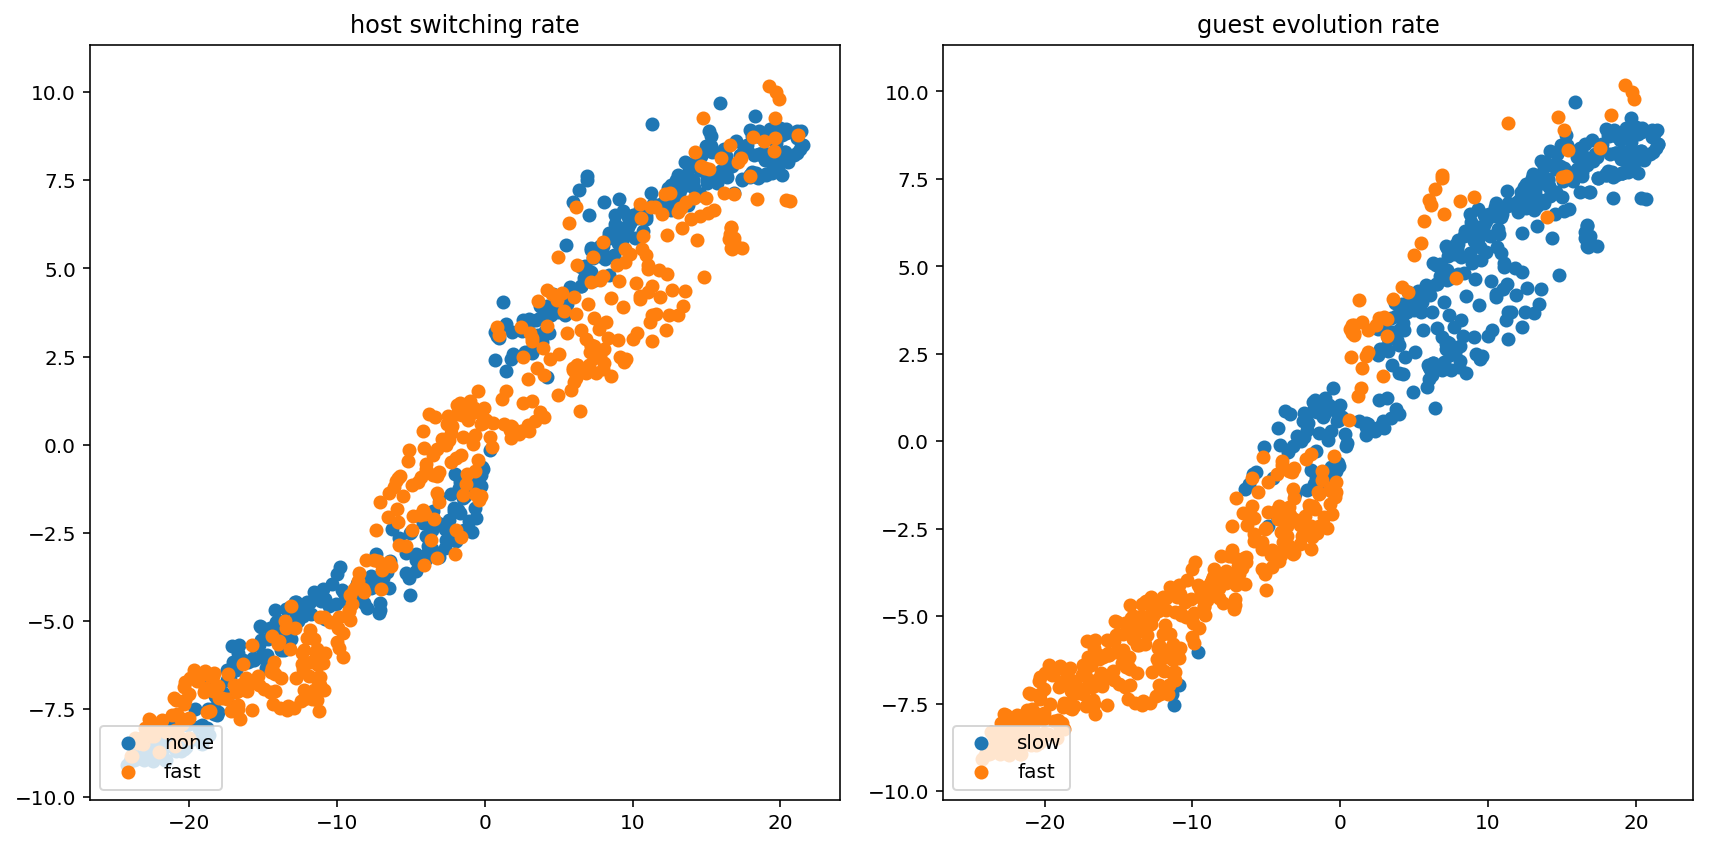

In [336]:
figure( figsize=(12,6) )

qq = q.dropna().join( gm_embedded )

xname,yname = gm_embedded.columns

subplot(1,2,1)
title( 'host switching rate' )
for l in set( qq.switch ) :
    scatter( qq[qq.switch==l][xname], qq[qq.switch==l][yname], label=l )
legend( loc=3 )

subplot(1,2,2)
title( 'guest evolution rate' )
for l in set( qq.g_evol ) :
    scatter( qq[qq.g_evol==l][xname], qq[qq.g_evol==l][yname], label=l )
legend( loc=3 )

tight_layout()

In [337]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = gm.dropna()
y = pandas.get_dummies( q.loc[X.index][['g_evol', 'switch']] )

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)

forest = RandomForestClassifier( n_estimators=1000,
                                 criterion='entropy',
                                 random_state=0,
                                 n_jobs=4 )

forest.fit( X_train, y_train )
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print( 'Feature ranking :' )
for f in range(X.shape[1]):
    print( '%d. feature %d : %f (%s)' % ( f + 1,
                                          indices[f],
                                          importances[indices[f]],
                                          X.columns[indices[f]] ) )

print( 'Score : %f' % ( forest.score( X_test, y_test ) ) )

Feature ranking :
1. feature 13 : 0.212004 (nestedness)
2. feature 11 : 0.149044 (std_betweenness)
3. feature 4 : 0.093462 (r)
4. feature 6 : 0.069294 (squareness)
5. feature 12 : 0.067947 (modularity)
6. feature 2 : 0.067887 (occupancy)
7. feature 10 : 0.064172 (mean_betweenness)
8. feature 9 : 0.055735 (eccentricity)
9. feature 7 : 0.054991 (kurtosis)
10. feature 1 : 0.044809 (skew)
11. feature 5 : 0.037049 (p)
12. feature 0 : 0.032576 (eigengap)
13. feature 3 : 0.031270 (treedist)
14. feature 8 : 0.019761 (diameter)
Score : 0.743750


Text(0,0.5,u'feature importance')

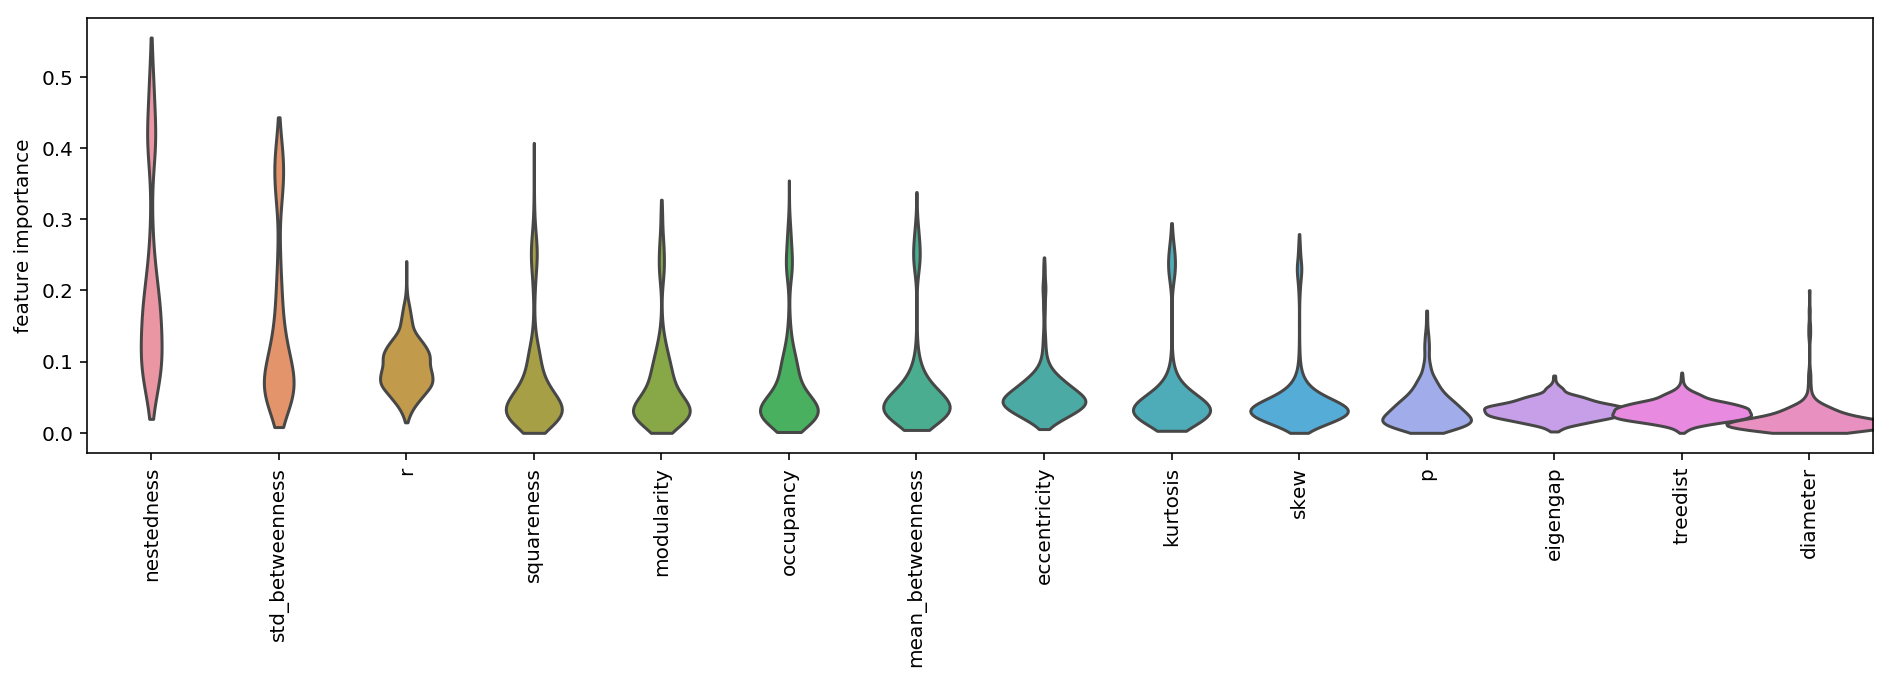

In [338]:
forest_imp = pandas.DataFrame( array( [tree.feature_importances_ for tree in forest.estimators_] ),
                               columns=X.columns)

figure( figsize=(16,4) )
seaborn.violinplot( x='variable',
                    y='value',
                    data=forest_imp.melt(),
                    order=X.columns[indices],
                    width=1.3, cut=0.001, inner=None )
xticks(range(X.shape[1]), rotation='vertical')
xlabel('')
ylabel('feature importance')

## Clustering with spectral distances

In [339]:
from pyprind import ProgBar

p = ProgBar( len(spectra)**2, title='calculating spectral distances...' )

s_d = zeros( ( len( spectra ), len( spectra ) ) )
for i in range( s_d.shape[0] ) :
    for j in range( s_d.shape[1] ) :
        p.update()
        s_d[i,j] = sqrt( 0.5 * ( entropy( spectra[i], spectra[j] ) + entropy( spectra[j], spectra[i] ) ) )

calculating spectral distances...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:57


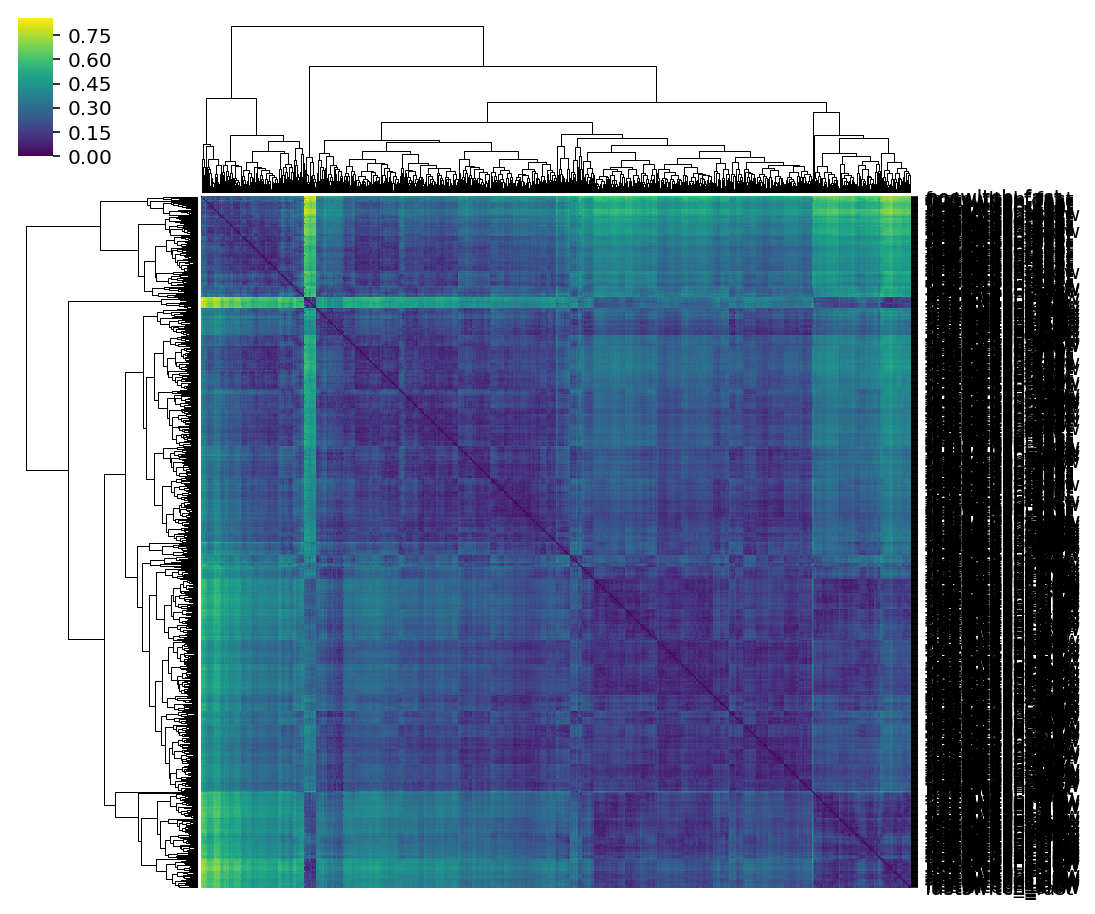

In [340]:
seaborn.clustermap( s_d, cmap='viridis', method='weighted', metric='euclidean', #metric='correlation',
                    figsize=(8,8), xticklabels=False, yticklabels=q.label )

In [341]:
from sklearn.manifold import TSNE, MDS, Isomap

sd_embedded = pandas.DataFrame( TSNE(n_components=2, perplexity=300).fit_transform( s_d ), 
                                columns=['tSNEx','tSNEy'] )
#sd_embedded = pandas.DataFrame( MDS(n_components=2, metric=True ).fit_transform( s_d ), 
#                                columns=['MDSx','MDSy'] )
#sd_embedded = pandas.DataFrame( Isomap(n_components=2 ).fit_transform( s_d ), 
#                                columns=['Isox','Isoy'] )

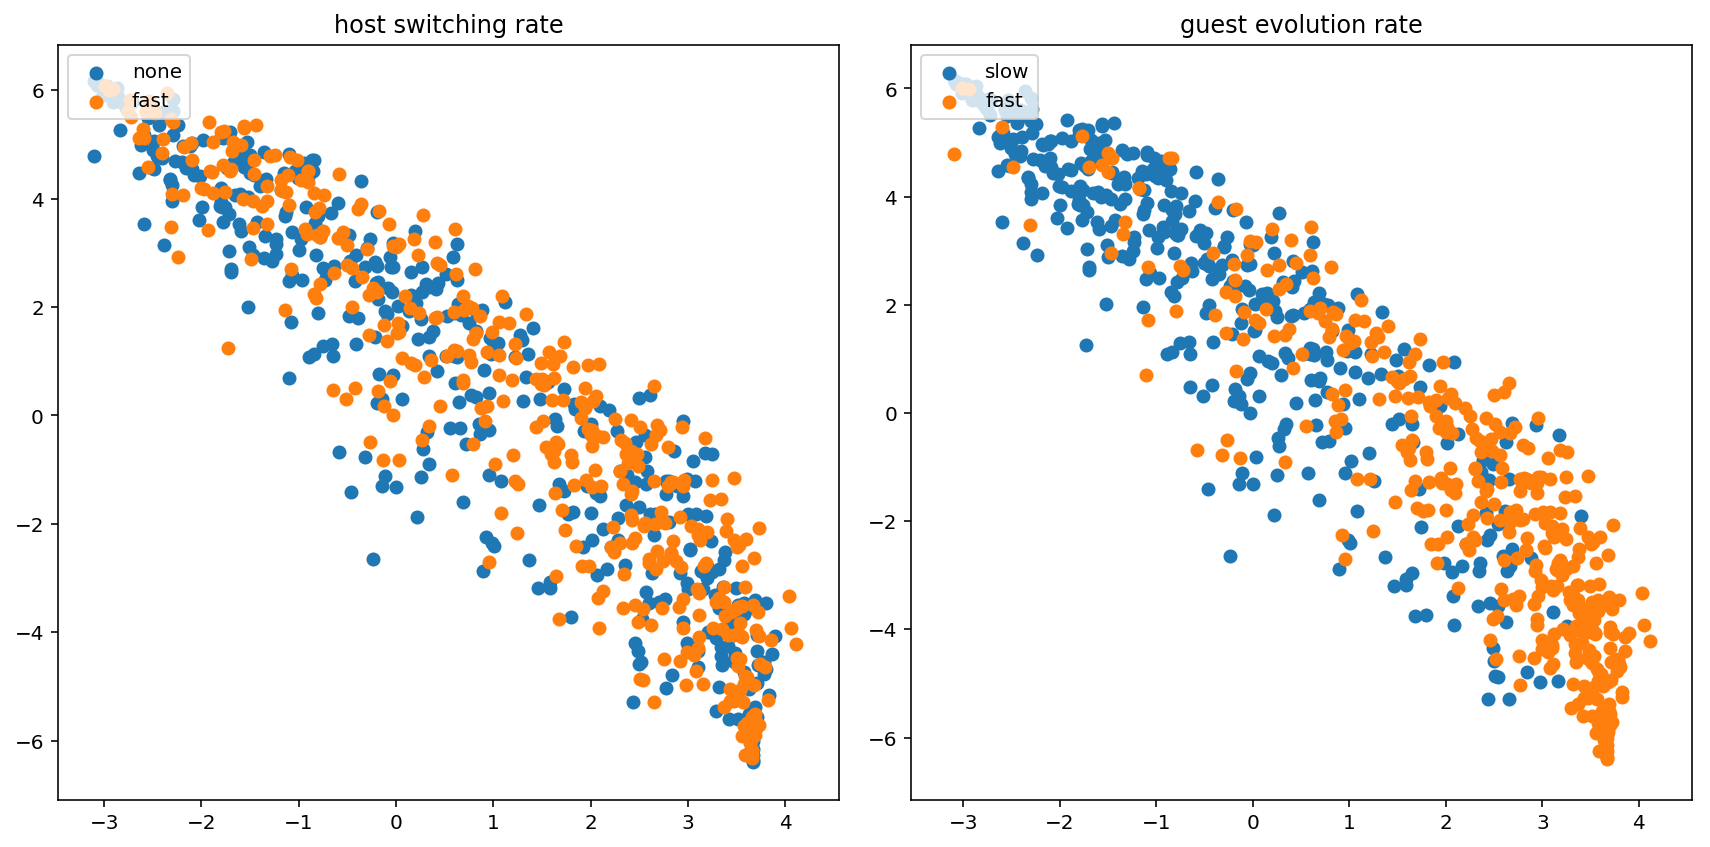

In [342]:
figure( figsize=(12,6) )

qq = q.join( sd_embedded )

subplot(1,2,1)
title( 'host switching rate' )
for l in set( qq.switch ) :
    scatter( qq[qq.switch==l]['tSNEx'], qq[qq.switch==l]['tSNEy'], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

subplot(1,2,2)
title( 'guest evolution rate' )
for l in set( qq.g_evol ) :
    scatter( qq[qq.g_evol==l]['tSNEx'], qq[qq.g_evol==l]['tSNEy'], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

tight_layout()

In [343]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#X = pandas.get_dummies( q[['g_evol', 'switch']] )
X = pandas.get_dummies( q[['label']] )
#y = pandas.DataFrame( g, index=q.index, columns=q.index )
y = s_d

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)


#forest = RandomForestClassifier( n_estimators=100,
#                                 criterion='entropy',
#                                 random_state=0,
#                                 n_jobs=4 )

forest = RandomForestRegressor( n_estimators=200,
                                #criterion='gini',
                                random_state=0,
                                n_jobs=4 )


forest.fit( X_train, y_train )
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print( 'Feature ranking :' )
for f in range(X.shape[1]):
    print( '%d. feature %d : %f (%s)' % ( f + 1,
                                          indices[f],
                                          importances[indices[f]],
                                          X.columns[indices[f]] ) )
    
print( 'Score : %f' % ( forest.score( X_test, y_test ) ) )

Feature ranking :
1. feature 3 : 0.490320 (label_noswitch_slow)
2. feature 1 : 0.477731 (label_fastswitch_slow)
3. feature 2 : 0.016525 (label_noswitch_fast)
4. feature 0 : 0.015424 (label_fastswitch_fast)
Score : 0.204367


Text(0,0.5,u'feature importance')

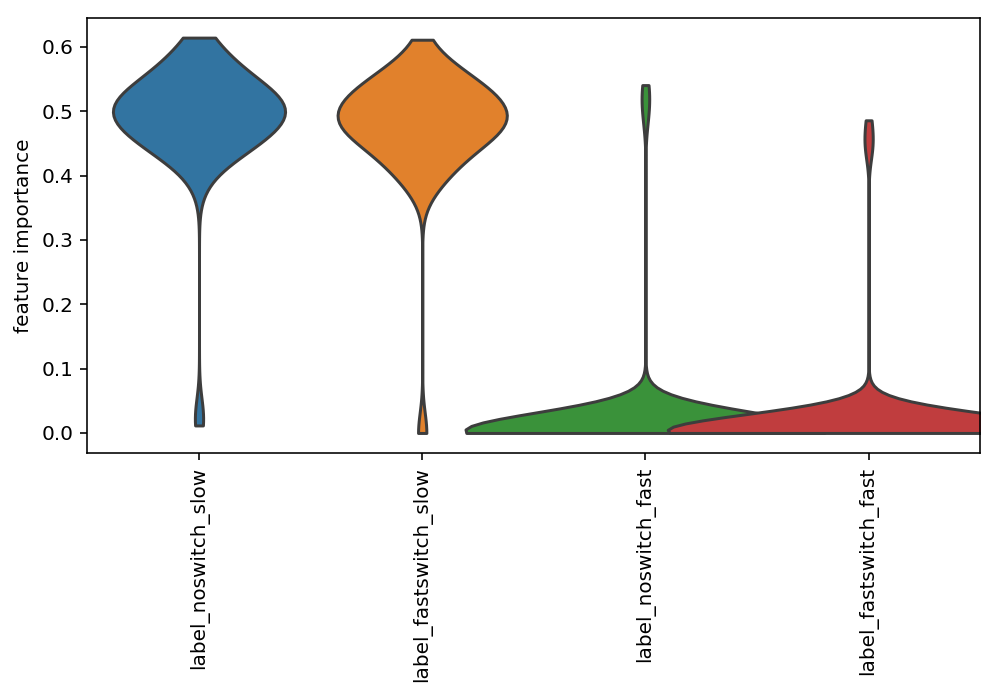

In [344]:
forest_imp = pandas.DataFrame( array( [tree.feature_importances_ for tree in forest.estimators_] ),
                               columns=X.columns)

figure( figsize=(8,4) )
seaborn.violinplot( x='variable',
                    y='value',
                    data=forest_imp.melt(),
                    order=X.columns[indices],
                    width=1.8, cut=0.001, inner=None )
xticks(range(X.shape[1]), rotation='vertical')
xlabel('')
ylabel('feature importance')

## Clustering with graph kernels

In [345]:
import graphkernels.kernels as gk

g = gk.CalculateConnectedGraphletKernel( igraphs )
#g = gk.CalculateEdgeHistGaussKernel( igraphs ) # nope
#g = gk.CalculateWLKernel( igraphs )
#g = gk.CalculateGraphletKernel( igraphs )
#g = gk.CalculateKStepRandomWalkKernel( igraphs ) # too big

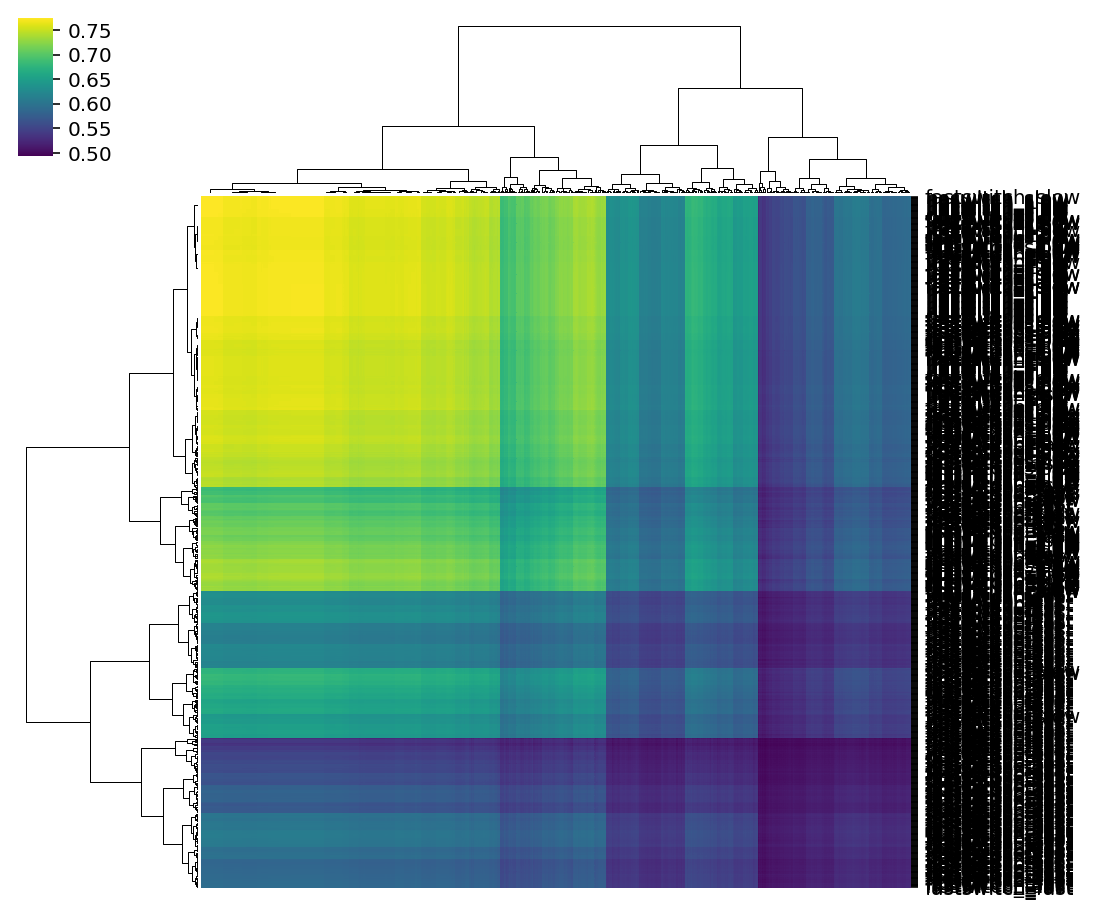

In [346]:
seaborn.clustermap( g, cmap='viridis', method='weighted', metric='euclidean',
                    figsize=(8,8), xticklabels=False, yticklabels=q.label )

Geraph kernels, being based on the tensor product graph, function a bit like
scalar products of graphs. Reasoning by analogy, we can use graph kernels to
construct a distance function.

For a graph kernel $G_k(A,B)$ that yeilds a scalar product of graphs $A$ and $B$,
we would like a function $d_k(A,B)$ that behaves like a distnace function. For vectors,

$ d^2 = \|\vec{B} - \vec{A}\| = (\vec{B}-\vec{A}) \cdot (\vec{B}-\vec{A}) \\
      = \vec{B} \cdot \vec{B} - \vec{B} \cdot \vec{A} - \vec{A} \cdot \vec{B} + \vec{A} \cdot \vec{A} \\
      = \| \vec{B} \|^2 - 2\vec{B} \cdot \vec{A} + \| \vec{A} \|^2 $
      
If $d_k(A,B)$ behaves like $d(\vec{A},\vec{B})$, then :

$d_k(A,B) = G_k(B,B) - 2G_k(B,A) + G_k(A,A)$

Using connected graphlet kernel, this seems to recover the order very well :

In [347]:
d_k = zeros( g.shape )
for i in range( g.shape[0] ) :
    for j in range( g.shape[1] ) :
        d_k[i,j] = sqrt( g[j,j] - 2*g[j,i] + g[i,i] )

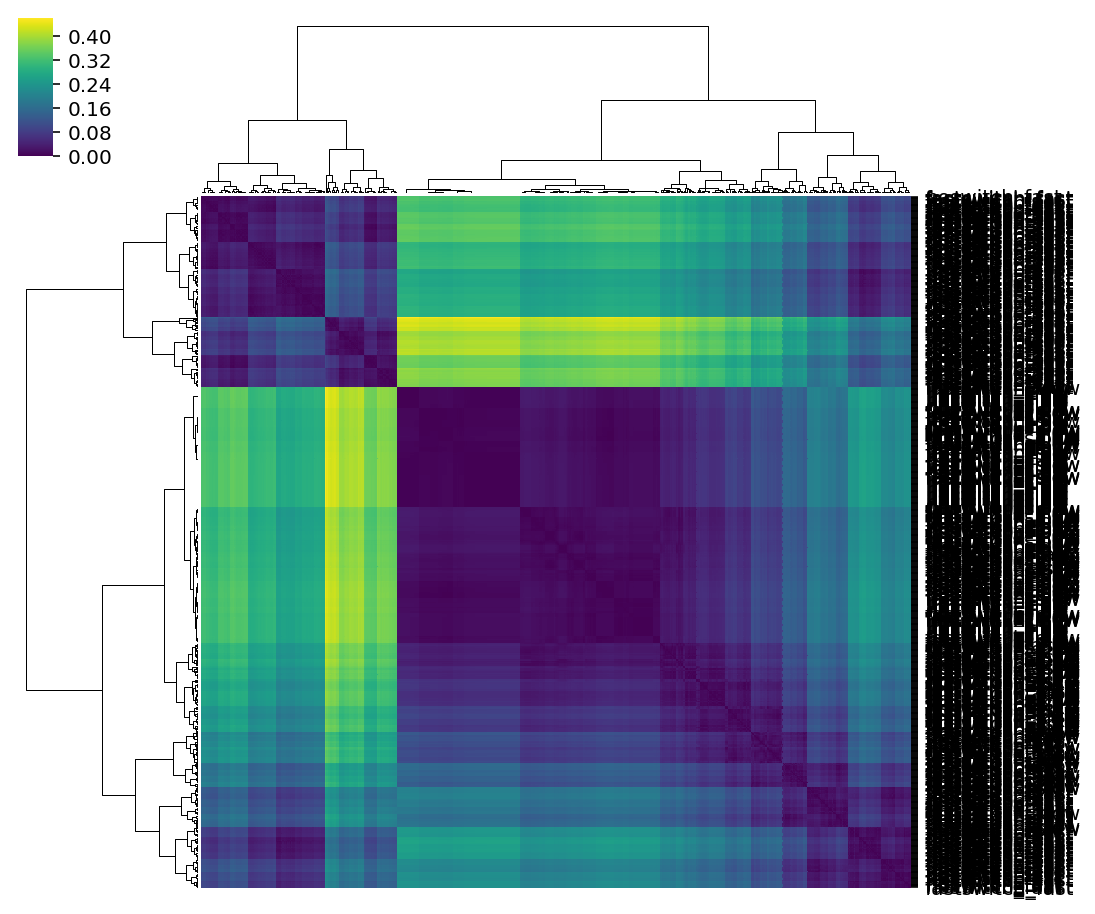

In [348]:
seaborn.clustermap( d_k, cmap='viridis', method='weighted', metric='euclidean',
                    figsize=(8,8), xticklabels=False, yticklabels=q.label )

In [386]:
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.decomposition import PCA


#dk_embedded = pandas.DataFrame( TSNE(n_components=2, perplexity=500).fit_transform( 
#                                PCA( n_components=10 ).fit_transform( g ) ),
#                                columns=['tSNEx','tSNEy'] )

#dk_embedded = pandas.DataFrame( SpectralEmbedding(n_components=2,n_neighbors=500).fit_transform( g ),
#                                columns=['SpecEmx','SpecEmy'] )

#dk_embedded = pandas.DataFrame( LocallyLinearEmbedding(n_components=2,n_neighbors=500).fit_transform( g ),
#                                columns=['LLEx','LLEy'] )

#dk_embedded = pandas.DataFrame( MDS(n_components=2, metric=True ).fit_transform( g ), 
#                                columns=['MDSx','MDSy'] )

#dk_embedded = pandas.DataFrame( Isomap(n_components=2 ).fit_transform( s_d ), 
#                                columns=['Isox','Isoy'] )

dk_embedded = pandas.DataFrame( PCA(n_components=2).fit_transform( g ),
                                columns=['gPCA1', 'gPCA2', ] )

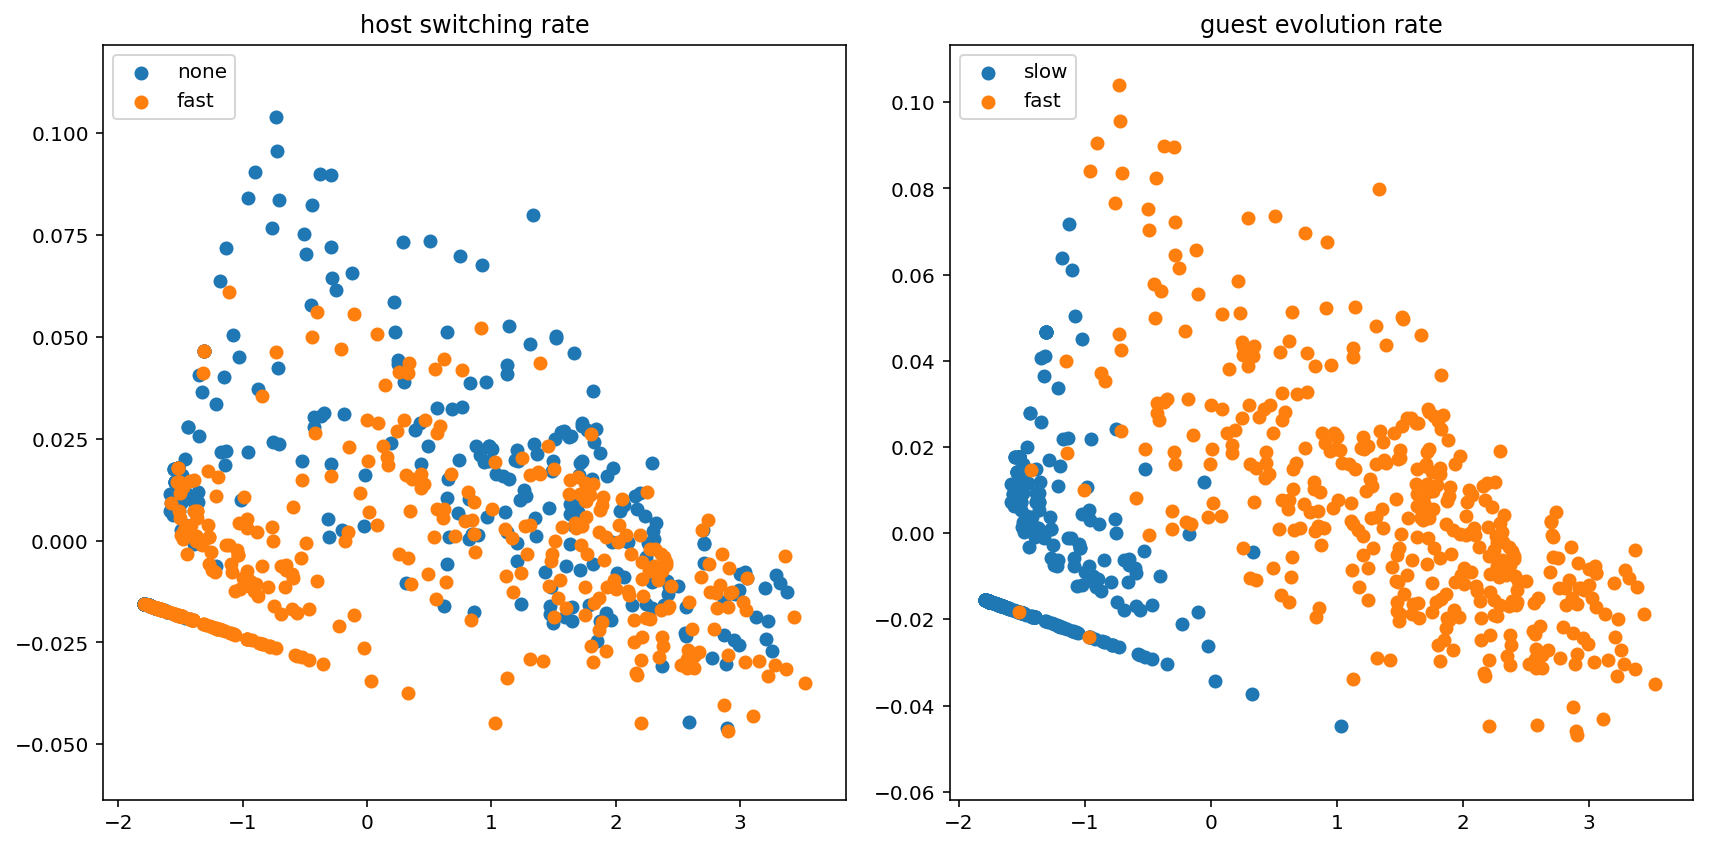

In [387]:
figure( figsize=(12,6) )

qq = q.join( dk_embedded )

xname,yname = dk_embedded.columns

subplot(1,2,1)
title( 'host switching rate' )
for l in set( qq.switch ) :
    scatter( qq[qq.switch==l][xname], qq[qq.switch==l][yname], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

subplot(1,2,2)
title( 'guest evolution rate' )
for l in set( qq.g_evol ) :
    scatter( qq[qq.g_evol==l][xname], qq[qq.g_evol==l][yname], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

tight_layout()

In [388]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import psutil

#X = pandas.get_dummies( q[['g_evol', 'switch']] )
X = pandas.get_dummies( q[['label']] )
#y = pandas.DataFrame( g, index=q.index, columns=q.index )
y = dk_embedded

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)


#forest = RandomForestClassifier( n_estimators=100,
#                                 criterion='entropy',
#                                 random_state=0,
#                                 n_jobs=4 )

forest = RandomForestRegressor( n_estimators=1000,
                                #criterion='gini',
                                random_state=0,
                                n_jobs=psutil.cpu_count()-2 )


forest.fit( X_train, y_train )
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print( 'Feature ranking :' )
for f in range(X.shape[1]):
    print( '%d. feature %d : %f (%s)' % ( f + 1,
                                          indices[f],
                                          importances[indices[f]],
                                          X.columns[indices[f]] ) )
    
print( 'Score : %f' % ( forest.score( X_test, y_test ) ) )

Feature ranking :
1. feature 1 : 0.530228 (label_fastswitch_slow)
2. feature 3 : 0.409892 (label_noswitch_slow)
3. feature 2 : 0.033206 (label_noswitch_fast)
4. feature 0 : 0.026674 (label_fastswitch_fast)
Score : 0.688536


Text(0,0.5,u'feature importance')

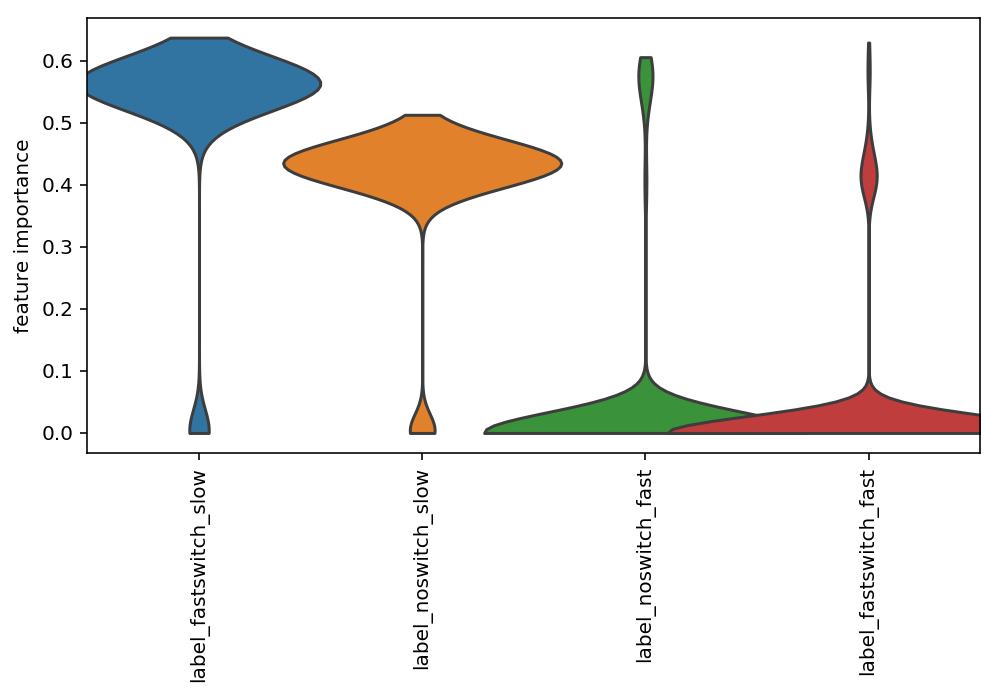

In [389]:
forest_imp = pandas.DataFrame( array( [tree.feature_importances_ for tree in forest.estimators_] ),
                               columns=X.columns)

figure( figsize=(8,4) )
seaborn.violinplot( x='variable',
                    y='value',
                    data=forest_imp.melt(),
                    order=X.columns[indices],
                    width=1.8, cut=0.001, inner=None )
xticks(range(X.shape[1]), rotation='vertical')
xlabel('')
ylabel('feature importance')

## Extended space of graph moments and graph kernels

In [423]:
pca = PCA( n_components=2 ).fit( gm[['nestedness', 
                                     'std_betweenness',
                                     'mean_betweenness',
                                     'r']] )
sum(pca.explained_variance_ratio_)

0.9999980686283587

In [428]:
pca = PCA( n_components=2 ).fit( g )

sum(pca.explained_variance_ratio_)

In [429]:
classic_features = pandas.DataFrame( pca.fit_transform(gm[['nestedness', 
                                                           'std_betweenness',
                                                           'mean_betweenness',
                                                           'r']]),
                                     columns=[ 'fPCA1', 'fPCA2' ] )

graphlet_features = pandas.DataFrame( PCA( n_components=2 ).fit_transform( g ), columns=['gPCA1', 'gPCA2', ] )
e_embedded = graphlet_features.join( classic_features )
e_embedded.head()

,gPCA1,gPCA2,fPCA1,fPCA2
0,-1.392449,0.009391,-113.287395,7.886435
1,-1.520849,0.017758,-145.936857,14.466473
2,-1.756704,-0.015896,-114.695372,5.541006
3,-1.763600,-0.015825,-149.564564,13.151144
4,-1.763600,-0.015825,-147.795256,12.744507


First, we'll train a classifier for host switching rate...

In [606]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

X = e_embedded

y = pandas.Categorical( q.loc[X.index]['switch'] ).codes
switch_catcodes = pandas.Categorical( q.loc[X.index]['switch'] ).categories

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0 )


classifier = MLPClassifier()
classifier.fit( X_train, y_train )
classifier.score( X_test, y_test )

0.8125

In [446]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    'learning_rate'      : [ 'constant', 'invscaling', 'adaptive' ],
    'hidden_layer_sizes' : [ (10,10,10), (10,20,30), (30,20,10), (20,30,10), (50,), (100,), (200,), (100,10), (100,10,100) ],
    'alpha'              : 10.0 ** -np.arange(1, 7),
    'activation'         : [ 'identity', 'logistic', 'relu', 'tanh'],
}

rf_random = RandomizedSearchCV( estimator = classifier,
                                param_distributions = random_grid,
                                n_iter = 100,
                                cv = 3,
                                verbose=1,
                                random_state=42,
                                n_jobs = -1)

rf_random.fit( X_train, y_train )

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.5s
/home/russell/opt/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/russell/opt/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/russell/opt/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/russell/opt/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perc

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]), 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'activation': ['identity', 'logistic', 'relu', 'tanh'], 'hidden_layer_sizes': [(10, 10, 10), (10, 20, 30), (30, 20, 10), (20, 30, 10), (50,), (100,), (200,), (100, 10), (100, 10, 100)]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn

In [447]:
best_switching_classifier = rf_random.best_estimator_
best_switching_classifier.score( X_test, y_test )

0.825

In [459]:
from sklearn.metrics import classification_report,confusion_matrix

print classification_report( y_test, best_switching_classifier.predict(X_test) )

             precision    recall  f1-score   support

          0       0.88      0.78      0.83        88
          1       0.77      0.88      0.82        72

avg / total       0.83      0.82      0.83       160



Next, we'll make a classifier for relative rates of evolution...

In [607]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

X = e_embedded

y = pandas.Categorical( q.loc[X.index]['g_evol'] ).codes
evol_catcodes = pandas.Categorical( q.loc[X.index]['g_evol'] ).categories

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0 )

classifier = MLPClassifier()
classifier.fit( X_train, y_train )
classifier.score( X_test, y_test )

0.93125

In [449]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    'learning_rate'      : [ 'constant', 'invscaling', 'adaptive' ],
    'hidden_layer_sizes' : [ (10,10,10), (10,20,30), (30,20,10), (20,30,10), (50,), (100,), (200,), (100,10), (100,10,100) ],
    'alpha'              : 10.0 ** -np.arange(1, 7),
    'activation'         : [ 'identity', 'logistic', 'relu', 'tanh'],
}

rf_random = RandomizedSearchCV( estimator = classifier,
                                param_distributions = random_grid,
                                n_iter = 100,
                                cv = 3,
                                verbose=1,
                                random_state=42,
                                n_jobs = -1)

rf_random.fit( X_train, y_train )

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/russell/opt/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/russell/opt/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/russell/opt/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/russell/opt/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conver

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]), 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'activation': ['identity', 'logistic', 'relu', 'tanh'], 'hidden_layer_sizes': [(10, 10, 10), (10, 20, 30), (30, 20, 10), (20, 30, 10), (50,), (100,), (200,), (100, 10), (100, 10, 100)]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn

In [450]:
best_evol_classifier = rf_random.best_estimator_
best_evol_classifier.score( X_test, y_test )

0.975

In [457]:
from sklearn.metrics import classification_report,confusion_matrix

print classification_report( y_test, best_evol_classifier.predict(X_test) )

             precision    recall  f1-score   support

          0       0.99      0.96      0.98        85
          1       0.96      0.99      0.97        75

avg / total       0.98      0.97      0.98       160



## Applying the classifiers to interactions from the literature

In [617]:
import json

data_path = '../SuchTree/'

def load_study( study ) :
    T1 = SuchTree( data_path + study['host'] )
    T2 = SuchTree( data_path + study['guest'] )
    LK = pandas.read_csv( data_path + study['links'], index_col=0 )
    LK = LK.loc[ T1.leafs.keys() ]
    LK = LK[ T2.leafs.keys() ]
    return SuchLinkedTrees( T1, T2, LK )
    
studies = json.load( open('../SuchTree/data/studies.json') )
study_slts = []
study_igraphs = []
study_names = []
study_types = []
for study in studies :
    if study['type'] == 'perfect' : continue
    if study['type'] == 'null' : continue
    SLT = load_study(study)
    study_slts.append( SLT )
    study_igraphs.append( SLT.to_igraph() )
    study_names.append( study['name'] )
    study_types.append( study['type'] )

/home/russell/opt/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [632]:
def hommola_corr( SLT ) :
    ld = SLT.linked_distances()
    return pearsonr( ld['TreeA'], ld['TreeB'] )[0]

gm_studies = pandas.DataFrame( zip(study_names, study_types), columns=['name', 'type'] )
gm_studies = gm_studies.join( pandas.DataFrame( [ mean(ig.betweenness()) for ig in study_igraphs ], columns=['mean_betweenness'] ) )
gm_studies = gm_studies.join( pandas.DataFrame( [ std(ig.betweenness()) for ig in study_igraphs ], columns=['std_betweenness'] ) )
gm_studies = gm_studies.join( pandas.DataFrame( [ nodf( SLT.linkmatrix )[0] for SLT in study_slts ], columns=['nestedness'] ) )
gm_studies = gm_studies.join( pandas.DataFrame( [ hommola_corr(SLT) for SLT in study_slts ], columns=['r'] ))

gm_studies.head()

,name,type,mean_betweenness,std_betweenness,nestedness,r
0,"Gopher, Lice",parasitism,142.225806,134.404876,0.008299,0.490185
1,"Sedge, Smut",parasitism,363.323077,291.225524,0.022894,0.151791
2,"Fish, Worm",parasitism,1474.329384,3755.602940,0.091365,0.548318
3,beeh,frugivory,79.589744,114.574014,0.739285,-0.036276
4,arr1,pollination,679.784916,1563.687545,0.135216,0.044583


In [619]:
# project the literature study features into the same space as
# our classic graph features
pca = pca.fit( gm[[ 'nestedness', 
                    'std_betweenness',
                    'mean_betweenness',
                    'r']] )

classic_features_lit = pandas.DataFrame( pca.transform( gm_studies[[ 'nestedness', 
                                                                     'std_betweenness',
                                                                     'mean_betweenness',
                                                                     'r']] ),
                                         columns=[ 'fPCA1', 'fPCA2' ] )

For the graphlet kernel products, we want to project into the same space
as the simulated interactions. Rather than $n\times n$ kernel products, we
want $n \times m$, where $n$ is the number of simulated interactions and $m$
is the number of interactions from the literature study.

In [633]:
# it seems kind silly to do all this extra computation, but running
# everything in the C++ library more than makes up for the difference
#     1 1 2 2 2
# 
# 1   1 1 2 2 2
# 1   1 1 2 2 2
# 2   2 2 4 4 4
# 2   2 2 4 4 4
# 2   2 2 4 4 4
N = len(igraphs)
M = len(study_igraphs)
g_lit = gk.CalculateConnectedGraphletKernel( study_igraphs + igraphs )
g_lit = pandas.DataFrame( g_lit )
g_lit = g_lit.loc[range(len(study_igraphs))][ range(M,M+N) ]
g_lit.columns = range(800)

# I'm very sorry about this, I had a headache and couldn't figure out array slicing

In [634]:
pca = PCA( n_components=2 ).fit( g )
pca.transform( g_lit )

graphlet_features_lit = pandas.DataFrame( PCA( n_components=2 ).fit_transform( g_lit ), columns=['gPCA1', 'gPCA2', ] )
e_embedded_lit = graphlet_features_lit.join( classic_features_lit )
e_embedded_lit.head()

,gPCA1,gPCA2,fPCA1,fPCA2
0,5.719208,-0.147548,-47.972718,-11.643101
1,5.112461,-0.133843,200.423584,-120.160749
2,-4.776490,-0.178177,3741.408221,715.101380
3,-1.421002,0.239570,-97.271393,31.784100
4,0.747438,-0.073924,1453.767810,265.108824


In [635]:
evol_predictions_lit   = [ evol_catcodes[i] for i in best_evol_classifier.predict( e_embedded_lit ) ]
switch_predictions_lit = [ switch_catcodes[i] for i in best_switching_classifier.predict( e_embedded_lit ) ]

In [636]:
gm_studies = gm_studies.join( pandas.DataFrame( evol_predictions_lit, columns=['predicted_evol']))
gm_studies = gm_studies.join( pandas.DataFrame( switch_predictions_lit, columns=['predicted_switching']))
gm_studies.head()

,name,type,mean_betweenness,std_betweenness,nestedness,r,predicted_evol,predicted_switching
0,"Gopher, Lice",parasitism,142.225806,134.404876,0.008299,0.490185,fast,fast
1,"Sedge, Smut",parasitism,363.323077,291.225524,0.022894,0.151791,fast,fast
2,"Fish, Worm",parasitism,1474.329384,3755.602940,0.091365,0.548318,fast,none
3,beeh,frugivory,79.589744,114.574014,0.739285,-0.036276,fast,none
4,arr1,pollination,679.784916,1563.687545,0.135216,0.044583,fast,none


In [637]:
gm_studies[['type','predicted_switching', 'predicted_evol']].to_csv('lit_predictions.csv')

In [638]:
set(gm_studies['type'])

{u'frugivory', u'parasitism', u'pollination'}

## Applying the classifiers to microbiome data

In [688]:
T1 = SuchTree( '../fishpoo/host_tree/mcgeetree/mcgee_trimmed.tree' )
T2 = SuchTree( '../fishpoo/microbe_tree/fishpoo.tree')
LK = pandas.read_csv( '../fishpoo/microbe_tree/fishpoo_abundance.tsv', sep='\t', index_col=0 )

In [689]:
LK = LK.drop( ['Kit control', 'Food', 'Water control', 'Charcoal control'])
LK.index = [ '_'.join(i.split()) for i in LK.index ] # NEWICK is the worst

for i in LK.index :
    print sorted((LK.loc[i]), reverse=True)[10000]

3.3157268239e-06
2.14124203458e-06
2.4483580087e-06
5.93912397921e-06
4.42317389266e-06
0.0
0.0
0.0
0.0
2.40116792808e-06
5.00768679924e-06
2.65817939521e-06
4.53315321605e-06
0.0


In [690]:
LK_cutoff = LK.apply( lambda x : x > 10e-6 )

In [692]:
SLT = SuchLinkedTrees( T1, T2, LK_cutoff )

In [734]:
progbar = ProgBar( len(SLT.TreeB.get_internal_nodes()), monitor=True, title='Chugging through microbime data...' )
#progbar = ProgBar( 1000, monitor=True, title='Chugging through microbime data...' )

fishpoo_igraphs = []
fishpoo_data = []
for n,nodeid in enumerate(SLT.TreeB.get_internal_nodes()) :
    #if n > 1000 : break
    SLT.subset_b( nodeid )
    progbar.update()
    if SLT.subset_b_size < 5 :
        continue
    if SLT.subset_n_links > 2500 :
        continue
    
    data = {}
    data['name'] = 'clade_' + str(nodeid)
    ig = SLT.to_igraph()
    fishpoo_igraphs.append(ig)
    betweenness = ig.betweenness()
    data['mean_betweenness'] = mean(betweenness)
    data['std_betweenness'] = std(betweenness)
    
    # this is only here because there's a bug in SLT.linkmatrix
    lk = zeros( (SLT.subset_a_size, SLT.subset_b_size) )
    a_leafs = list( SLT.subset_a_leafs )
    b_leafs = list( SLT.subset_b_leafs )
    for j,i in SLT.linklist :
        I,J = a_leafs.index(i), b_leafs.index(j)
        lk[I,J] = 1
    
    data['nestedness'] = nodf( lk )[0]
    
    ld = SLT.linked_distances()
    
    data['r'] = pearsonr( ld['TreeA'], ld['TreeB'] )[0]
    
    fishpoo_data.append(data)

Chugging through microbime data...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 11:17:42


In [739]:
fishpoo_data = pandas.DataFrame( fishpoo_data ).set_index('name')
fishpoo_data.head()

,mean_betweenness,nestedness,r,std_betweenness
name,,,,
clade_125,1006.211864,0.021492,-0.113734,1634.751685
clade_159421,3777.085843,0.005680,-0.037933,6639.218706
clade_121,587.513158,0.045010,-0.138239,989.298103
clade_127,310.518182,0.105217,-0.125883,462.289194
clade_158329,2815.035294,0.009372,-0.085288,5584.569422


In [741]:
# project the literature study features into the same space as
# our classic graph features
pca = pca.fit( gm[[ 'nestedness', 
                    'std_betweenness',
                    'mean_betweenness',
                    'r']] )

classic_features_fishpoo = pandas.DataFrame( pca.transform( fishpoo_data.dropna() ),
                                             columns=[ 'fPCA1', 'fPCA2' ] )
classic_features_fishpoo.head()

,fPCA1,fPCA2
0,-236.448634,48.640482
1,-236.250080,71.996163
2,-236.473141,45.644167
3,-236.431065,43.199267
4,-236.367627,67.053736


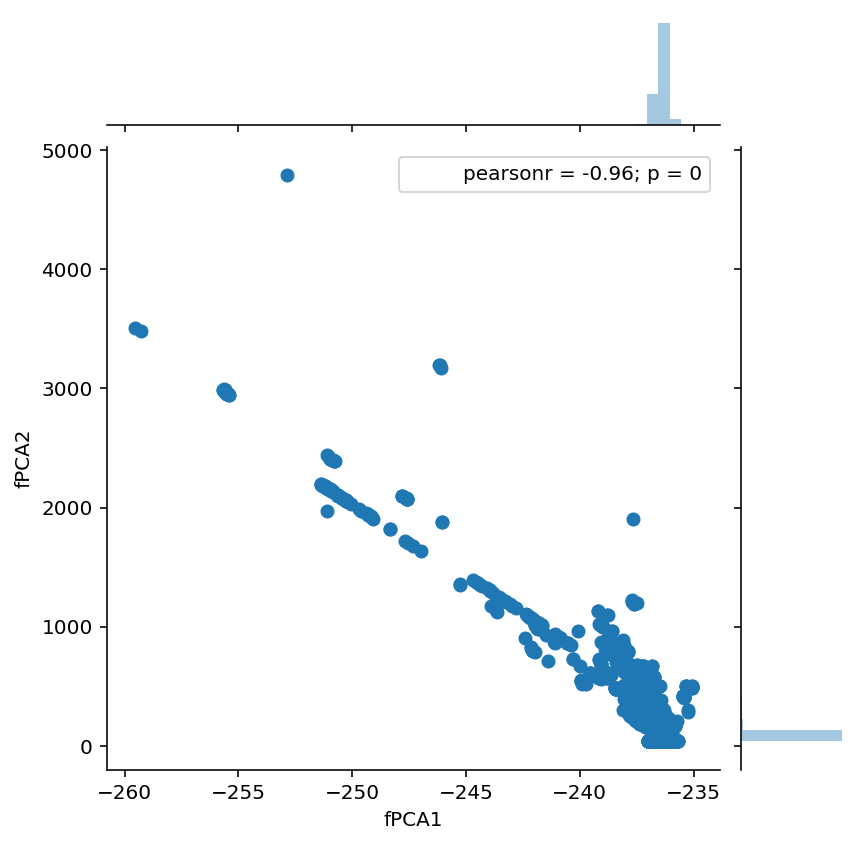

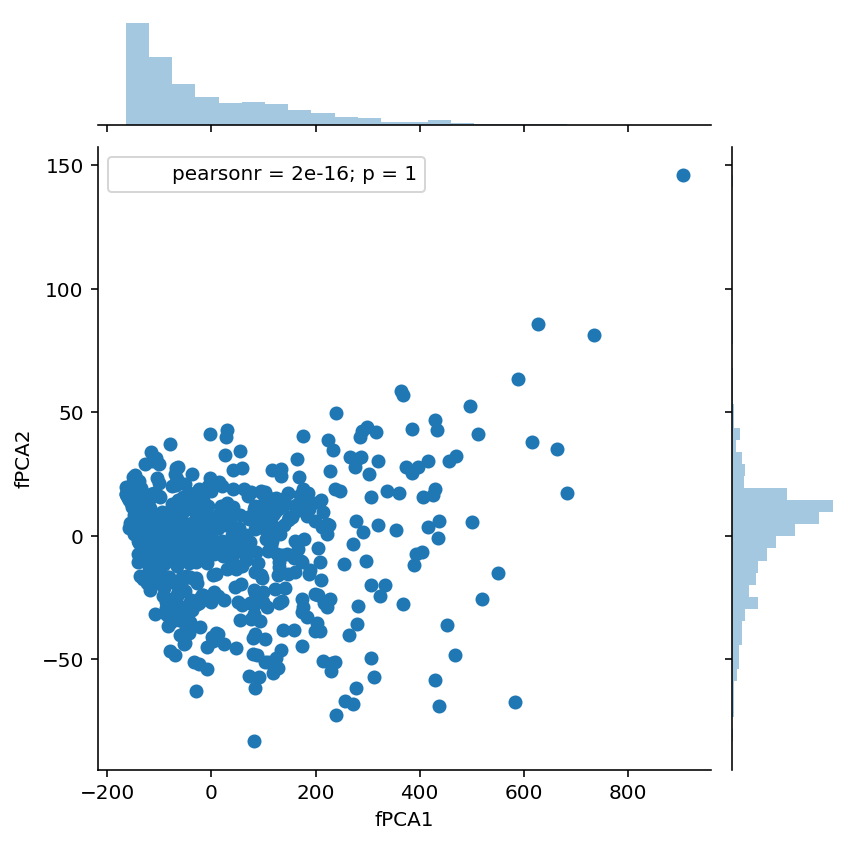

In [743]:
seaborn.jointplot( x='fPCA1', y='fPCA2', data=classic_features_fishpoo )
seaborn.jointplot( x='fPCA1', y='fPCA2', data=e_embedded )

In [748]:
fishpoo_data.to_csv('fishpoo_classical_features.csv')

In [763]:
from operator import itemgetter

fishpoo_sample = fishpoo_data.dropna().sample( 2000 )

fishpoo_sample_index = [ list(fishpoo_data.index).index(i) for i in fishpoo_sample.index ]

g_fishpoo = gk.CalculateConnectedGraphletKernel( list(itemgetter(*fishpoo_sample_index)(fishpoo_igraphs))
                                                 + igraphs )

N = len(igraphs)
M = len(study_igraphs)

g_fishpoo = pandas.DataFrame( g_fishpoo )
g_fishpoo = g_fishpoo.loc[range(len(fishpoo_sample))][ range(len(fishpoo_sample), 
                                                       len(fishpoo_sample)+len(igraphs)) ]
g_fishpoo.columns = range(800)

# I'm very sorry about this, I had a headache and couldn't figure out array slicing

In [765]:
pca = PCA( n_components=2 ).fit( g )
pca.transform( g_fishpoo )

graphlet_features_fishpoo = pandas.DataFrame( PCA( n_components=2 ).fit_transform( g_fishpoo ), columns=['gPCA1', 'gPCA2', ] )
e_embedded_fishpoo = graphlet_features_fishpoo.join( classic_features_fishpoo )
e_embedded_fishpoo.head()

,gPCA1,gPCA2,fPCA1,fPCA2
0,-1.610762,0.026682,-236.448634,48.640482
1,-1.822076,0.017130,-236.250080,71.996163
2,1.416149,0.052614,-236.473141,45.644167
3,5.722609,-0.086455,-236.431065,43.199267
4,2.398090,0.123189,-236.367627,67.053736


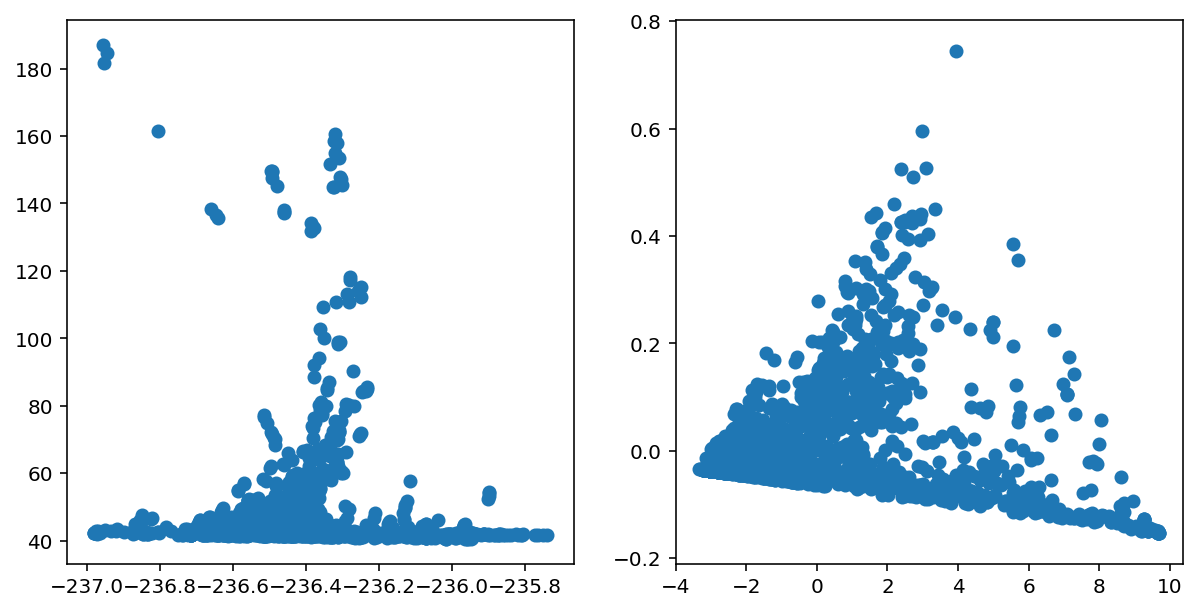

In [770]:
figure(figsize=(10,5))
subplot(1,2,1)
scatter( e_embedded_fishpoo['fPCA1'], e_embedded_fishpoo['fPCA2'] )
subplot(1,2,2)
scatter( e_embedded_fishpoo['gPCA1'], e_embedded_fishpoo['gPCA2'] )

In [772]:
evo_predictions_fishpoo_sample    = [ evol_catcodes[i] for i in best_evol_classifier.predict( e_embedded_fishpoo ) ]
switch_predictions_fishpoo_sample = [ switch_catcodes[i] for i in best_switching_classifier.predict( e_embedded_fishpoo ) ]

In [790]:
#e_embedded_fishpoo.join( pandas.DataFrame( [evo_predictions_fishpoo_sample,
#                                            switch_predictions_fishpoo_sample],
#                                            columns=['predicted_evol','predicted_switching']  ) )

fishpoo_predictions = e_embedded_fishpoo.join( pandas.DataFrame( { 'predicted_evol'      : evo_predictions_fishpoo_sample,
                                                                   'predicted_switching' : switch_predictions_fishpoo_sample } ) )
fishpoo_predictions.head()

,gPCA1,gPCA2,fPCA1,fPCA2,predicted_evol,predicted_switching
0,-1.610762,0.026682,-236.448634,48.640482,fast,none
1,-1.822076,0.017130,-236.250080,71.996163,fast,none
2,1.416149,0.052614,-236.473141,45.644167,fast,none
3,5.722609,-0.086455,-236.431065,43.199267,fast,none
4,2.398090,0.123189,-236.367627,67.053736,fast,none


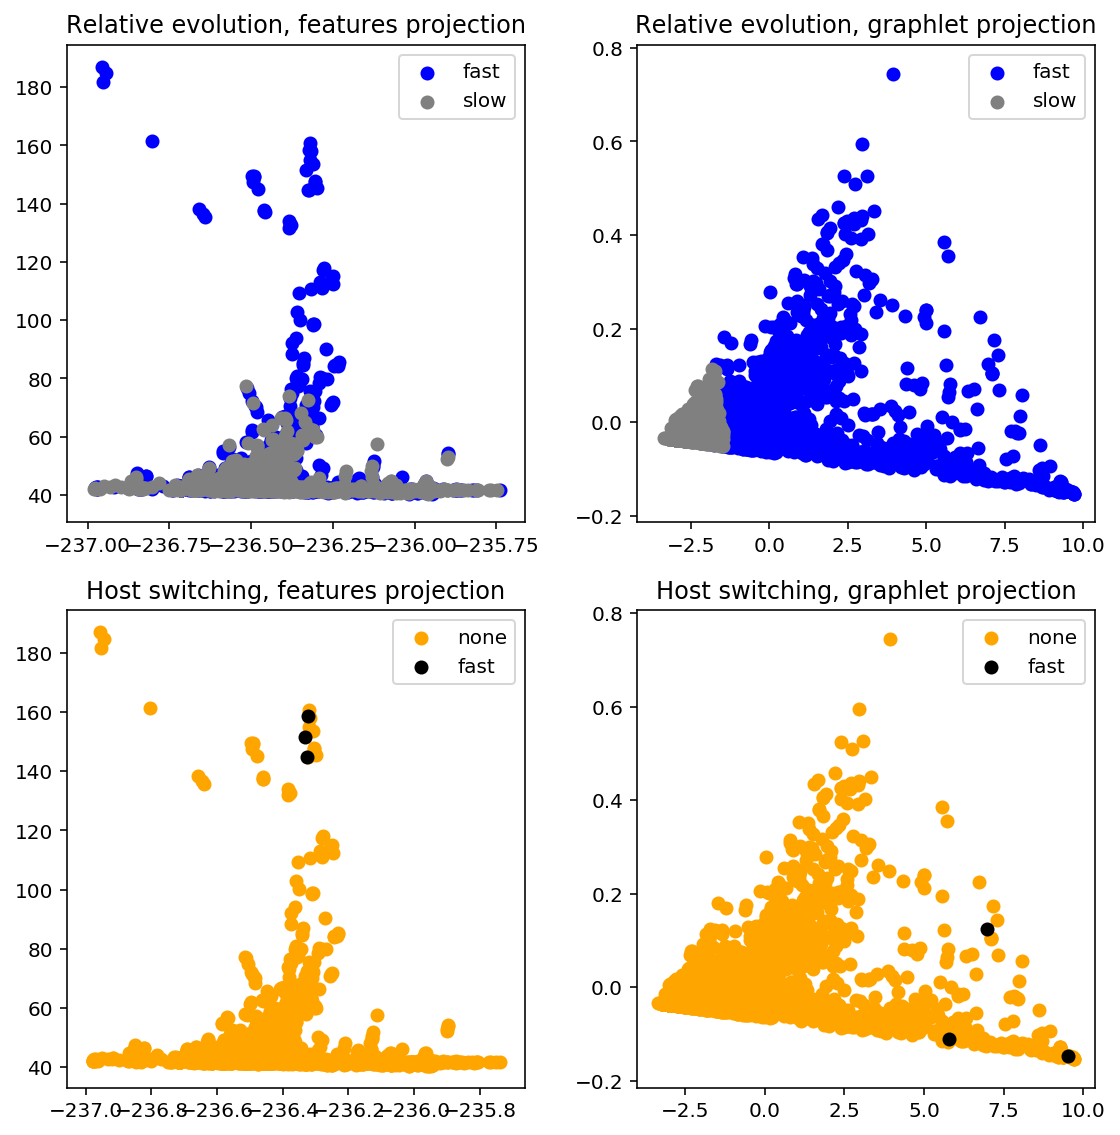

In [801]:
figure(figsize=(8,8))

subplot(2,2,1)
title( 'Relative evolution, features projection')
for evo,c in ( ('fast','blue'),('slow','gray') ) :
    temp_df = fishpoo_predictions[ fishpoo_predictions.predicted_evol == evo ]
    scatter( temp_df['fPCA1'], temp_df['fPCA2'], color=c, label=evo )
legend()
    
subplot(2,2,2)
title( 'Relative evolution, graphlet projection')
for evo,c in ( ('fast','blue'),('slow','gray') ) :
    temp_df = fishpoo_predictions[ fishpoo_predictions.predicted_evol == evo ]
    scatter( temp_df['gPCA1'], temp_df['gPCA2'], color=c, label=evo )
legend()
    
subplot(2,2,3)
title( 'Host switching, features projection')
for switching,c in ( ('none','orange'),('fast','black') ) :
    temp_df = fishpoo_predictions[ fishpoo_predictions.predicted_switching == switching ]
    scatter( temp_df['fPCA1'], temp_df['fPCA2'], color=c, label=switching )
legend()

subplot(2,2,4)
title( 'Host switching, graphlet projection')
for switching,c in ( ('none','orange'),('fast','black') ) :
    temp_df = fishpoo_predictions[ fishpoo_predictions.predicted_switching == switching ]
    scatter( temp_df['gPCA1'], temp_df['gPCA2'], color=c, label=switching )
legend()
    
tight_layout()
savefig( '' )